In [1]:
from __future__ import print_function, division
from builtins import range, input

In [3]:
!unzip '/content/drive/MyDrive/Recommender_Systems/archive.zip'

Archive:  /content/drive/MyDrive/Recommender_Systems/archive.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [4]:
import pandas as pd
df = pd.read_csv('/content/rating.csv')
df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [6]:
# make the user ids go from 0...N-1
df.userId = df.userId - 1

In [7]:
# create a mapping for movie ids
unique_movie_ids = set(df.movieId.values)
movie2idx = {}
count = 0
for movie_id in unique_movie_ids:
  movie2idx[movie_id] = count
  count += 1

In [8]:
movie2idx

{131072: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59,
 60: 60,
 61: 61,
 62: 62,
 63: 63,
 64: 64,
 65: 65,
 66: 66,
 67: 67,
 68: 68,
 69: 69,
 70: 70,
 71: 71,
 72: 72,
 73: 73,
 74: 74,
 75: 75,
 76: 76,
 77: 77,
 78: 78,
 79: 79,
 80: 80,
 81: 81,
 82: 82,
 83: 83,
 84: 84,
 85: 85,
 86: 86,
 87: 87,
 88: 88,
 89: 89,
 90: 90,
 131162: 91,
 92: 92,
 93: 93,
 94: 94,
 95: 95,
 96: 96,
 97: 97,
 98: 98,
 99: 99,
 100: 100,
 101: 101,
 102: 102,
 103: 103,
 104: 104,
 105: 105,
 106: 106,
 107: 107,
 108: 108,
 109: 109,
 

In [9]:
# add them to the data frame
# takes awhile
df['movie_idx'] = df.apply(lambda row: movie2idx[row.movieId], axis=1)
df

,userId,movieId,rating,timestamp,movie_idx
0,0,2,3.5,2005-04-02 23:53:47,2
1,0,29,3.5,2005-04-02 23:31:16,29
2,0,32,3.5,2005-04-02 23:33:39,32
3,0,47,3.5,2005-04-02 23:32:07,47
4,0,50,3.5,2005-04-02 23:29:40,50
...,...,...,...,...,...
20000258,138492,68954,4.5,2009-11-13 15:42:00,13821
20000259,138492,69526,4.5,2009-12-03 18:31:48,13929
20000260,138492,69644,3.0,2009-12-07 18:10:57,13942
20000261,138492,70286,5.0,2009-11-13 15:42:24,14060


In [10]:
df = df.drop(columns=['timestamp'])
df.to_csv('edited_rating.csv', index=False)

In [11]:
import pickle
import numpy as np
import pandas as pd
from collections import Counter

In [12]:
print("original dataframe size:", len(df))

original dataframe size: 20000263


In [13]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

user_ids_count = Counter(df.userId)
movie_ids_count = Counter(df.movie_idx)

In [14]:
# number of users and movies we would like to keep
n = 10000
m = 2000

user_ids = [u for u, c in user_ids_count.most_common(n)]
movie_ids = [m for m, c in movie_ids_count.most_common(m)]

In [15]:
df_small = df[df.userId.isin(user_ids) & df.movie_idx.isin(movie_ids)].copy()

In [16]:
# need to remake user ids and movie ids since they are no longer sequential
new_user_id_map = {}
i = 0
for old in user_ids:
  new_user_id_map[old] = i
  i += 1
print("i:", i)

new_movie_id_map = {}
j = 0
for old in movie_ids:
  new_movie_id_map[old] = j
  j += 1
print("j:", j)

i: 10000
j: 2000


In [17]:
print("Setting new ids")
df_small.loc[:, 'userId'] = df_small.apply(lambda row: new_user_id_map[row.userId], axis=1)
df_small.loc[:, 'movie_idx'] = df_small.apply(lambda row: new_movie_id_map[row.movie_idx], axis=1)
# df_small.drop(columns=['userId', 'movie_idx'])
# df_small.rename(index=str, columns={'new_userId': 'userId', 'new_movie_idx': 'movie_idx'})
print("max user id:", df_small.userId.max())
print("max movie id:", df_small.movie_idx.max())

Setting new ids
max user id: 9999
max movie id: 1999


In [19]:
print("small dataframe size:", len(df_small))
df_small.to_csv('/content/drive/MyDrive/Recommender_Systems/small_rating.csv', index=False)

small dataframe size: 5392025


In [20]:
from sklearn.utils import shuffle

# load in the data
# https://www.kaggle.com/grouplens/movielens-20m-dataset
df = df_small

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [21]:
# a dictionary to tell us which users have rated which movies
user2movie = {}
# a dicationary to tell us which movies have been rated by which users
movie2user = {}
# a dictionary to look up ratings
usermovie2rating = {}
print("Calling: update_user2movie_and_movie2user")
count = 0
def update_user2movie_and_movie2user(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movie_idx)
  if i not in user2movie:
    user2movie[i] = [j]
  else:
    user2movie[i].append(j)

  if j not in movie2user:
    movie2user[j] = [i]
  else:
    movie2user[j].append(i)

  usermovie2rating[(i,j)] = row.rating
df_train.apply(update_user2movie_and_movie2user, axis=1)

Calling: update_user2movie_and_movie2user
processed: 0.023
processed: 0.046
processed: 0.070
processed: 0.093
processed: 0.116
processed: 0.139
processed: 0.162
processed: 0.185
processed: 0.209
processed: 0.232
processed: 0.255
processed: 0.278
processed: 0.301
processed: 0.325
processed: 0.348
processed: 0.371
processed: 0.394
processed: 0.417
processed: 0.440
processed: 0.464
processed: 0.487
processed: 0.510
processed: 0.533
processed: 0.556
processed: 0.580
processed: 0.603
processed: 0.626
processed: 0.649
processed: 0.672
processed: 0.695
processed: 0.719
processed: 0.742
processed: 0.765
processed: 0.788
processed: 0.811
processed: 0.835
processed: 0.858
processed: 0.881
processed: 0.904
processed: 0.927
processed: 0.950
processed: 0.974
processed: 0.997


16859307    None
16683255    None
15671005    None
15826318    None
6990383     None
            ... 
19431425    None
13069521    None
13820706    None
9540343     None
8813971     None
Length: 4313620, dtype: object

In [24]:
# test ratings dictionary
usermovie2rating_test = {}
print("Calling: update_usermovie2rating_test")
count = 0
def update_usermovie2rating_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movie_idx)
  usermovie2rating_test[(i,j)] = row.rating
df_test.apply(update_usermovie2rating_test, axis=1)

Calling: update_usermovie2rating_test
processed: 0.093
processed: 0.185
processed: 0.278
processed: 0.371
processed: 0.464
processed: 0.556
processed: 0.649
processed: 0.742
processed: 0.835
processed: 0.927


15533435    None
446321      None
287968      None
11088202    None
4478395     None
            ... 
8881002     None
7576606     None
8184947     None
5003726     None
12479839    None
Length: 1078405, dtype: object

In [26]:
with open('/content/drive/MyDrive/Recommender_Systems/user2movie.json', 'wb') as f:
  pickle.dump(user2movie, f)

with open('/content/drive/MyDrive/Recommender_Systems/movie2user.json', 'wb') as f:
  pickle.dump(movie2user, f)

with open('/content/drive/MyDrive/Recommender_Systems/usermovie2rating.json', 'wb') as f:
  pickle.dump(usermovie2rating, f)

with open('/content/drive/MyDrive/Recommender_Systems/usermovie2rating_test.json', 'wb') as f:
  pickle.dump(usermovie2rating_test, f)

In [27]:
from datetime import datetime
import os

In [28]:
with open('user2movie.json', 'rb') as f:
  user2movie = pickle.load(f)

with open('movie2user.json', 'rb') as f:
  movie2user = pickle.load(f)

with open('usermovie2rating.json', 'rb') as f:
  usermovie2rating = pickle.load(f)

with open('usermovie2rating_test.json', 'rb') as f:
  usermovie2rating_test = pickle.load(f)

In [29]:
N = np.max(list(user2movie.keys())) + 1
# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)

N: 10000 M: 2000


In [30]:
# initialize variables
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N)
U = np.random.randn(M, K)
c = np.zeros(M)
mu = np.mean(list(usermovie2rating.values()))

# prediction[i,j] = W[i].dot(U[j]) + b[i] + c.T[j] + mu

In [31]:
def get_loss(d):
  # d: (user_id, movie_id) -> rating
  N = float(len(d))
  sse = 0
  for k, r in d.items():
    i, j = k
    p = W[i].dot(U[j]) + b[i] + c[j] + mu
    sse += (p - r)*(p - r)
  return sse / N

In [32]:
# train the parameters
epochs = 25
reg =20. # regularization penalty
train_losses = []
test_losses = []
for epoch in range(epochs):
  print("epoch:", epoch)
  epoch_start = datetime.now()
  # perform updates

  # update W and b
  t0 = datetime.now()
  for i in range(N):
    # for W
    matrix = np.eye(K) * reg
    vector = np.zeros(K)

    # for b
    bi = 0
    for j in user2movie[i]:
      r = usermovie2rating[(i,j)]
      matrix += np.outer(U[j], U[j])
      vector += (r - b[i] - c[j] - mu)*U[j]
      bi += (r - W[i].dot(U[j]) - c[j] - mu)

    # set the updates
    W[i] = np.linalg.solve(matrix, vector)
    b[i] = bi / (len(user2movie[i]) + reg)

    if i % (N//10) == 0:
      print("i:", i, "N:", N)
  print("updated W and b:", datetime.now() - t0)

  # update U and c
  t0 = datetime.now()
  for j in range(M):
    # for U
    matrix = np.eye(K) * reg
    vector = np.zeros(K)

    # for c
    cj = 0
    try:
      for i in movie2user[j]:
        r = usermovie2rating[(i,j)]
        matrix += np.outer(W[i], W[i])
        vector += (r - b[i] - c[j] - mu)*W[i]
        cj += (r - W[i].dot(U[j]) - b[i] - mu)

      # set the updates
      U[j] = np.linalg.solve(matrix, vector)
      c[j] = cj / (len(movie2user[j]) + reg)

      if j % (M//10) == 0:
        print("j:", j, "M:", M)
    except KeyError:
      # possible not to have any ratings for a movie
      pass
  print("updated U and c:", datetime.now() - t0)
  print("epoch duration:", datetime.now() - epoch_start)


  # store train loss
  t0 = datetime.now()
  train_losses.append(get_loss(usermovie2rating))

  # store test loss
  test_losses.append(get_loss(usermovie2rating_test))
  print("calculate cost:", datetime.now() - t0)
  print("train loss:", train_losses[-1])
  print("test loss:", test_losses[-1])

epoch: 0
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:01:16.172871
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:01:17.552304
epoch duration: 0:02:33.726866
calculate cost: 0:00:10.638101
train loss: 0.6929160152027116
test loss: 0.702261859785165
epoch: 1
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:01:15.100047
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:01:16.303519
epoch duration: 0:02:31.404995
calculate cost: 0:00:10.549080
train loss: 0.5705659618586357

train losses: [0.6929160152027116, 0.5705659618586357, 0.5344491532150788, 0.5232121395807696, 0.5179879120282058, 0.5153748316037603, 0.513884060552131, 0.513010182993279, 0.5124429226154742, 0.5120745068571085, 0.5118047279174811, 0.5116033806744165, 0.5114327082812182, 0.511284814094513, 0.5111456387231298, 0.5110157109545973, 0.5108918385983843, 0.510777799253402, 0.5106741171924684, 0.5105835891826638, 0.5105059557424715, 0.5104414569735778, 0.5103884521083886, 0.5103457573416806, 0.5103114633287787]
test losses: [0.702261859785165, 0.5963080368756314, 0.5632028303399306, 0.551738950743062, 0.5465475187991614, 0.5438157676553189, 0.5423655872738692, 0.5414672792279347, 0.5409238823419468, 0.5405363605232638, 0.5402660189557696, 0.5400414512677607, 0.5398563839704277, 0.5396833664537323, 0.5395247595950841, 0.539372199268413, 0.5392310315197136, 0.5391009443597128, 0.5389862905631594, 0.5388875908377448, 0.5388056898232173, 0.5387393929896713, 0.5386869535091819, 0.5386463789612856

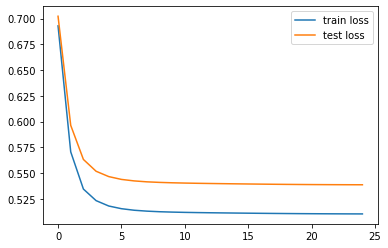

In [34]:
import matplotlib.pyplot as plt
print("train losses:", train_losses)
print("test losses:", test_losses)

# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()